In [1]:
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
from sklearn.model_selection import train_test_split
import torch
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(1)
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models, transforms, utils
from tqdm.auto import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class RRN(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.n_steps = n_steps
        make_mlp = lambda i: nn.Sequential(
                                nn.Linear(i,96), nn.ReLU(),
                                nn.Linear(96,96), nn.ReLU(),
                                nn.Linear(96,96), nn.ReLU(),
                                nn.Linear(96,16)
                            )
        self.inp_enc = make_mlp(25)
        self.msg_enc = make_mlp(32)
        self.msg_comb = make_mlp(32)
        self.lstm_cell = nn.LSTMCell(16,16)
        self.decoder = nn.Linear(16,8)
        self.rc = self.get_rc()
        self.l, self.r = self.get_lr()
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        
    def get_rc(self):
        t = F.one_hot(torch.arange(8, device=X.device))
        rc = torch.cat((t.repeat(8,1), t.repeat(1,8).view(-1,8)), dim=-1)
        return rc.float()
    
    def get_lr(self):
        l, r = [], []
        for i in range(8):
            for j in range(8):
                start = 8*i+j
                for x in range(8):
                    end = 8*i+x
                    l.append(start)
                    r.append(end)
                    end = 8*x+j
                    l.append(start)
                    r.append(end)
                block_start_x = i//2*2
                block_start_y = j//4*4
                for x in range(2):
                    for y in range(4):
                        X, Y = block_start_x + x, block_start_y + y
                        end = 8*X + Y
                        l.append(start)
                        r.append(end)
        return torch.tensor(l, dtype=torch.long), torch.tensor(r, dtype=torch.long)
    
    def forward(self, X):
        b = X.shape[0]
        X = X.view(-1,64,9)
        RC = self.rc[None,:,:].to(X.device).expand(b,-1,-1)
        X = self.inp_enc(torch.cat((RC, X.float()), dim=-1)).view(-1,16)
        H = X
        C = torch.zeros_like(H)
        self.out = []
        for step in range(self.n_steps):
            Hv = H.view(-1,64,16)
            M = torch.zeros(b,64,64,16, device=H.device)
            M[:,self.l,self.r,:] = self.msg_enc(torch.cat((Hv[:,self.l,:], Hv[:,self.r,:]), dim=-1))
            XM = self.msg_comb(torch.cat((X, torch.sum(M, dim=-2).view(-1,16)), dim=-1))
            H, C = self.lstm_cell(XM, (H, C))
            self.out.append(self.decoder(H))
        return self.out[-1].view(-1,512)
    
    def criterion(self, y_true, X_pred):
        y_true = y_true.view(-1)
        s = 0
        self.losses = []
        for step in range(self.n_steps):
            l = self.cross_entropy_loss(self.out[step], y_true)
            self.losses.append(l.item())
            s += l
        return s

In [4]:
def load_sudoku_images(path, total, device, normalize=False):
    sudoku_img = torch.empty(total,1,224,224, device=device)
    if normalize:
        transform = transforms.Compose((
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))))
    else:
        transform = transforms.ToTensor()
    for i in tqdm(range(total), 'sudoku images'):
        sudoku_img[i,0] = transform(Image.open(f'{path}/{i}.png'))
    return sudoku_img # (-1, 1, 224, 224)

In [5]:
x = torch.load('data/pt-cache/query_y.pt').to(device)
y = torch.load('data/pt-cache/target_y.pt').to(device)
X = F.one_hot(x.long().view(-1,8,8), num_classes=9).view(-1,576)
y = y.view(-1,64).long()
net = RRN(24).to(device)

In [6]:
ctr = 0
losses = [[] for _ in range(32)]

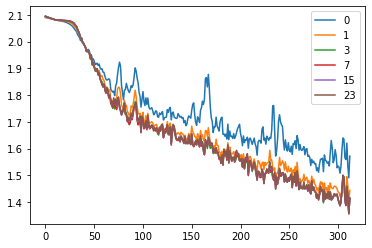

KeyboardInterrupt: 

In [7]:
loader = DataLoader(TensorDataset(X,y), batch_size=32, shuffle=True)
opt = optim.Adam(net.parameters(), lr=1e-3)
while True:
    for Xb, yb in tqdm(loader, 'batches'):
        ctr += 1
        loss = net.criterion(yb-1, net(Xb))
        for i in range(net.n_steps):
            losses[i].append(net.losses[i])
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), 1)
        opt.step()
        
        if ctr % 10 == 0:
            for i in [0,1,3,7,15,23]:
                print(f'{losses[i][-1]:.3f}', end='\t')
            print()

    plt.figure()
    for i in [0,1,3,7,15,23]:
        plt.plot(losses[i], label=f'{i}')
    plt.legend()
    display.clear_output(wait=True)
    plt.show()